In [134]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Resizing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from zoopt import Dimension, Objective, Parameter, Opt

In [135]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.17.0
Num GPUs Available:  1


In [136]:
#clear GPU memory
ops.reset_default_graph()
tf.keras.backend.clear_session()

In [137]:
# Constants
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 10 

In [138]:
# Load Data
def loading_data(dataset_path):
    filepaths = []
    labels = []
    folds = os.listdir(dataset_path)
    for fold in folds:
        foldpath = os.path.join(dataset_path, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    Fseries = pd.Series(filepaths, name='filepath')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)
    return df


In [139]:
# Change label names
def change_label_name(df, column_name):
    index = {
        'lun_Opac': 'Lung_Opacity',
        'normal': 'Normal',
        'Viral_pneu': 'Viral_pneumonia',    
    }
    df[column_name] = df[column_name].replace(index)

In [140]:
dataset_path = "/home/idrone2/Desktop/Lung X-Ray Image"
df = loading_data(dataset_path)

In [141]:
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
)

change_label_name(df, 'labels')

Found 3475 files belonging to 3 classes.


In [142]:
# Data Balancing
data_balance = df.labels.value_counts()

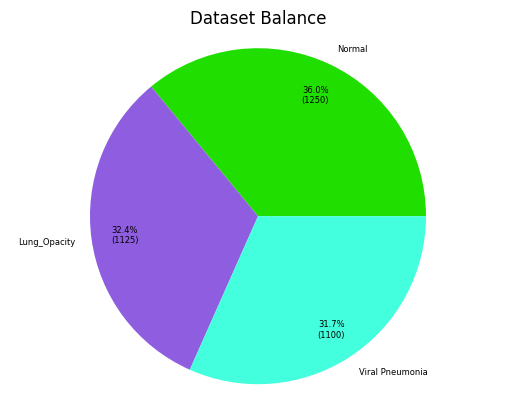

In [143]:
def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

colors = ['#20df00', '#8f5ddf', '#44ffdd']
plt.pie(data_balance, autopct=custom_autopct, labels=data_balance.index, colors=colors, textprops={'fontsize':6}, pctdistance=0.8, labeldistance=1.1)
plt.title("Dataset Balance")
plt.axis("equal")
plt.show()

In [144]:
# Calculate the sizes of each dataset split
dataset_size = len(image_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

In [145]:
# Shuffle and split the dataset
image_dataset = image_dataset.shuffle(buffer_size=dataset_size, seed=123)
train_ds = image_dataset.take(train_size)
val_ds = image_dataset.skip(train_size).take(val_size)
test_ds = image_dataset.skip(train_size + val_size)

In [146]:
# Preprocessing and caching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [147]:
# Resizing and rescaling layer
# resize_and_rescale = tf.keras.Sequential([
#     tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
#     tf.keras.layers.Rescaling(1./255),
# ])

In [148]:
# # Load and preprocess the CIFAR-10 dataset as a placeholder for your dataset
# def load_data():
#     (train_images, train_labels), (val_images, val_labels) = tf.keras.datasets.load_data()
#     train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
#     val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
#     return train_ds, val_ds

In [149]:
# train_ds, val_ds = load_data()
# train_ds = train_ds.shuffle(buffer_size=10000).batch(16).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = val_ds.batch(16).prefetch(buffer_size=tf.data.AUTOTUNE)

In [150]:
# # Split the dataset into training, validation, and testing
# dataset_size = len(image_dataset)
# train_size = int(0.8 * dataset_size)
# val_size = int(0.1 * dataset_size)
# test_size = dataset_size - train_size - val_size

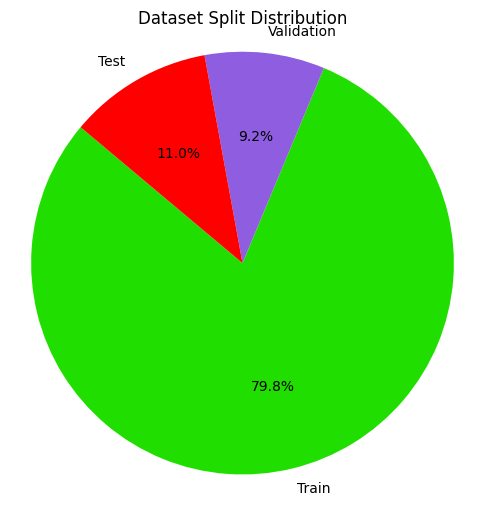

In [151]:
# Dataset Split Distribution
labels = ['Train', 'Validation', 'Test']
colors = ['#20df00', '#8f5ddf', 'red']
plt.figure(figsize=(6, 6))
plt.pie([train_size, val_size, test_size], labels=labels, autopct="%1.1f%%", startangle=140, colors=colors)
plt.title('Dataset Split Distribution')
plt.axis('equal')
plt.show()

In [152]:
# for batch in train_ds.take(1):
#     images, labels = batch
#     print(images.shape) 

In [175]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model


In [176]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [177]:
def create_model(learning_rate, dropout_rate, num_layers):
    # Define the correct input shape for your dataset
    input_shape = (256, 256, 3)
    inputs = Input(shape=input_shape)
    
    # Add Conv2D and MaxPooling2D layers
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    
    # Print the output shape after Flatten
    print("Flatten output shape:", x.shape)
    
    # Add Dense layers with Dropout
    for _ in range(int(num_layers)):
        x = Dense(64, activation='relu')(x)
        x = Dropout(dropout_rate)(x)
    
    # Add the output layer
    outputs = Dense(3, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [178]:
print(f"Expected input shape: (None, {IMAGE_SIZE}, {IMAGE_SIZE}, {CHANNELS})")


Expected input shape: (None, 256, 256, 3)


In [179]:
# Define the evaluation function for ZOOpt
def evaluate_model(solution):
    params = solution.get_x()  # Retrieve the parameter values from the Solution object
    learning_rate, dropout_rate, num_layers = params

    # Create and train the model
    model = create_model(learning_rate, dropout_rate, int(num_layers))
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=0
    )

    # Get the highest validation accuracy
    val_accuracy = max(history.history['val_accuracy'])
    return 1 - val_accuracy  # Return the inverse of accuracy for minimization

In [180]:
# Check for GPU availability
if tf.test.gpu_device_name():
    print("ZOOpt is running on GPU.")
else:
    print("ZOOpt is running on CPU.")

print("Configuring ZOOpt parameters...")

ZOOpt is running on GPU.
Configuring ZOOpt parameters...


I0000 00:00:1724037959.757013    4488 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724037959.764415    4488 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724037959.767994    4488 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724037959.771284    4488 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [181]:
# ZOOpt Configuration
dim = Dimension(
    3,
    [
        (1e-3, 1e-1),  # Learning rate range
        (0.0, 0.5),   # Dropout rate range
        (1, 5)        # Number of layers range
    ],
    [
        True,  # Learning rate is continuous
        True,  # Dropout rate is continuous
        False  # Number of layers is discrete
    ]
)
objective = Objective(lambda solution: evaluate_model(solution), dim)
parameter = Parameter(budget=10, exploration_rate=0.1)

print("Starting the optimization process...")
# Optimize
solution = Opt.min(objective, parameter)
print("Optimization completed.")

# Extract the best parameters
best_params = solution.get_x()
print("Best parameters:", best_params)
print(f"Learning rate: {best_params[0]}")
print(f"Dropout rate: {best_params[1]}")
print(f"Number of layers: {best_params[2]}")

Starting the optimization process...
Flatten output shape: (None, 258064)
Flatten output shape: (None, 258064)
Flatten output shape: (None, 258064)
Flatten output shape: (None, 258064)


2024-08-19 08:56:48.932528: W external/local_tsl/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 63.00MiB (rounded to 66064384)requested by op 
2024-08-19 08:56:48.932644: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-08-19 08:56:48.932649: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 5223, Chunks in use: 5223. 1.27MiB allocated for chunks. 1.27MiB in use in bin. 135.8KiB client-requested in use in bin.
2024-08-19 08:56:48.932652: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 2065, Chunks in use: 2064. 1.10MiB allocated for chunks. 1.10MiB in use in bin. 1.01MiB client-requested in use in bin.
2024-08-19 08:56:48.932654: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (1024): 	Total Chunks: 41, Chunks in use: 41. 65.2KiB allocated for chunks. 65.2KiB in use in bin. 63.1KiB client-requested in use in bi

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/idrone2/.local/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/idrone2/.local/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/local/lib/python3.11/asyncio/base_events.py", line 604, in run_forever

  File "/usr/local/lib/python3.11/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/local/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/idrone2/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/idrone2/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/idrone2/.local/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/idrone2/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/idrone2/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/idrone2/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_4488/4006107568.py", line 20, in <module>

  File "/home/idrone2/.local/lib/python3.11/site-packages/zoopt/opt.py", line 50, in min

  File "/home/idrone2/.local/lib/python3.11/site-packages/zoopt/algos/opt_algorithms/racos/racos_optimization.py", line 57, in opt

  File "/home/idrone2/.local/lib/python3.11/site-packages/zoopt/algos/opt_algorithms/racos/sracos.py", line 47, in opt

  File "/home/idrone2/.local/lib/python3.11/site-packages/zoopt/algos/opt_algorithms/racos/racos_common.py", line 92, in init_attribute

  File "/home/idrone2/.local/lib/python3.11/site-packages/zoopt/objective.py", line 83, in eval

  File "/tmp/ipykernel_4488/4006107568.py", line 15, in <lambda>

  File "/tmp/ipykernel_4488/381330677.py", line 8, in evaluate_model

  File "/home/idrone2/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/idrone2/.local/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/idrone2/.local/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 66064384 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  213.16MiB
              constant allocation:         2B
        maybe_live_out allocation:  189.16MiB
     preallocated temp allocation:  232.56MiB
  preallocated temp fragmentation:       380B (0.00%)
                 total allocation:  445.72MiB
              total fragmentation:    13.3KiB (0.00%)
Peak buffers:
	Buffer 1:
		Size: 63.00MiB
		Operator: op_type="MaxPoolGrad" op_name="gradient_tape/functional_8_1/max_pooling2d_8_1/MaxPool2d/MaxPoolGrad" source_file="/home/idrone2/.local/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: select-and-scatter
		Shape: f16[32,254,254,16]
		==========================

	Buffer 2:
		Size: 63.00MiB
		Operator: op_type="Conv2D" op_name="functional_8_1/conv2d_8_1/convolution" source_file="/home/idrone2/.local/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f16[32,254,254,16]
		==========================

	Buffer 3:
		Size: 63.00MiB
		Operator: op_type="Relu" op_name="functional_8_1/conv2d_8_1/Relu"
		XLA Label: fusion
		Shape: f16[32,254,254,16]
		==========================

	Buffer 4:
		Size: 63.00MiB
		Operator: op_type="If" op_name="cond" source_file="/home/idrone2/.local/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: fusion
		Shape: f32[258064,64]
		==========================

	Buffer 5:
		Size: 63.00MiB
		Operator: op_type="If" op_name="cond" source_file="/home/idrone2/.local/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: fusion
		Shape: f32[258064,64]
		==========================

	Buffer 6:
		Size: 63.00MiB
		Operator: op_type="If" op_name="cond" source_file="/home/idrone2/.local/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: fusion
		Shape: f32[258064,64]
		==========================

	Buffer 7:
		Size: 24.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[32,256,256,3]
		==========================

	Buffer 8:
		Size: 15.75MiB
		Operator: op_type="MatMul" op_name="gradient_tape/functional_8_1/dense_30_1/MatMul/MatMul" source_file="/home/idrone2/.local/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f16[32,258064]
		==========================

	Buffer 9:
		Size: 15.75MiB
		Operator: op_type="MaxPool" op_name="functional_8_1/max_pooling2d_8_1/MaxPool2d" source_file="/home/idrone2/.local/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: fusion
		Shape: f16[32,127,127,16]
		==========================

	Buffer 10:
		Size: 12.00MiB
		Operator: op_type="Cast" op_name="functional_8_1/Cast" source_file="/home/idrone2/.local/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: fusion
		Shape: f16[32,256,256,3]
		==========================

	Buffer 11:
		Size: 16.0KiB
		Operator: op_type="If" op_name="cond" source_file="/home/idrone2/.local/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1177 deduplicated_name="loop_select_fusion.5"
		XLA Label: fusion
		Shape: f32[64,64]
		==========================

	Buffer 12:
		Size: 16.0KiB
		Operator: op_type="If" op_name="cond" source_file="/home/idrone2/.local/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1177 deduplicated_name="loop_select_fusion.5"
		XLA Label: fusion
		Shape: f32[64,64]
		==========================

	Buffer 13:
		Size: 16.0KiB
		Operator: op_type="If" op_name="cond" source_file="/home/idrone2/.local/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1177 deduplicated_name="loop_select_fusion.5"
		XLA Label: fusion
		Shape: f32[64,64]
		==========================

	Buffer 14:
		Size: 16.0KiB
		Operator: op_type="If" op_name="cond" source_file="/home/idrone2/.local/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1177 deduplicated_name="loop_select_fusion.5"
		XLA Label: fusion
		Shape: f32[64,64]
		==========================

	Buffer 15:
		Size: 16.0KiB
		Operator: op_type="If" op_name="cond" source_file="/home/idrone2/.local/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1177 deduplicated_name="loop_select_fusion.5"
		XLA Label: fusion
		Shape: f32[64,64]
		==========================


	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_15822264]

In [58]:
# Create the best model with the best parameters
best_model = create_model(best_params[0], best_params[1], best_params[2])

In [59]:
best_model.summary()

Model: "sequential_201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_201 (Conv2D)             │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_201               │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_201 (Flatten)           │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_855 (Dense)               │ (None, 128)            │       921,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_654 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_856 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_655 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_857 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_656 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_858 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_657 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_859 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 973,450 (3.71 MB)

 Trainable params: 973,450 (3.71 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Train the best model
history = best_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 4s 922us/step - accuracy: 0.3340 - loss: 2.3264 - val_accuracy: 0.5090 - val_loss: 1.3626
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 838us/step - accuracy: 0.5308 - loss: 1.3238 - val_accuracy: 0.5575 - val_loss: 1.2448
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 841us/step - accuracy: 0.5832 - loss: 1.1764 - val_accuracy: 0.5923 - val_loss: 1.1880
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 853us/step - accuracy: 0.6300 - loss: 1.0638 - val_accuracy: 0.5944 - val_loss: 1.1925
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 853us/step - accuracy: 0.6609 - loss: 0.9666 - val_accuracy: 0.6170 - val_loss: 1.1313
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 854us/step - accuracy: 0.6848 - loss: 0.8985 - val_accuracy: 0.6165 - val_loss: 1.1523
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 824us/step - accuracy: 0.7137 - loss: 0.8253 - val_accuracy: 0.6122 - val_loss: 1.1765
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 832us/step - accuracy: 0.7377 -

In [68]:
# Step 1: Check the Output Shape of the Model
for images, labels in test_ds.take(1):
    preds = best_model.predict(images)
    print("Model output shape:", preds.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Model output shape: (16, 10)


2024-08-14 16:25:36.480114: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━

2024-08-14 16:18:58.379542: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


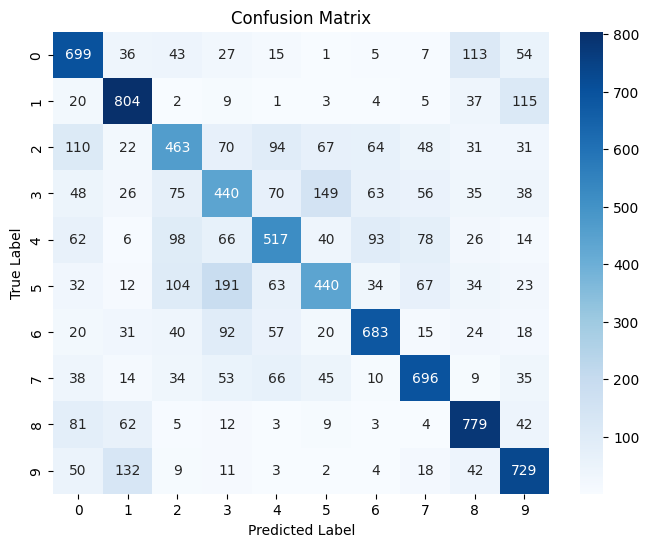

In [61]:
# Step 2: Generate Predictions
true_labels = []
pred_labels = []

for images, labels in test_ds:
    preds = best_model.predict(images)
    pred_labels.extend(np.argmax(preds, axis=1))
    true_labels.extend(labels.numpy().flatten())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

In [62]:
# Generate classification report
target_names = ['Lung_Opacity', 'Normal', 'Viral_pneumonia']
report = classification_report(true_labels, pred_labels, target_names=target_names)
print("Classification Report:\n", report)

ValueError: Number of classes, 10, does not match size of target_names, 3. Try specifying the labels parameter

In [63]:
# Generate CAM for a sample image from the test set
def get_cam_model(model, last_conv_layer_name="conv2d"):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    cam_model = models.Model([model.inputs], [last_conv_layer.output, model.output])
    return cam_model

In [64]:
def plot_cam(image, cam_heatmap, alpha=0.4, colormap='viridis'):
    plt.imshow(image, alpha=1)
    plt.imshow(cam_heatmap, cmap=colormap, alpha=alpha)
    plt.axis('off')
    plt.show()

In [65]:
def generate_cam(image, model, last_conv_layer_name="conv2d"):
    cam_model = get_cam_model(model, last_conv_layer_name)
    conv_outputs, predictions = cam_model.predict(np.expand_dims(image, axis=0))
    conv_outputs = conv_outputs[0]
    class_idx = np.argmax(predictions[0])
    cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[:2])
    for i, w in enumerate(cam_model.layers[-1].get_weights()[0][:, class_idx]):
        cam += w * conv_outputs[:, :, i]
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = tf.image.resize(cam, (IMAGE_SIZE, IMAGE_SIZE))
    return cam.numpy()

In [66]:
# Visualize CAM for a sample image from the test set
for images, labels in test_ds.take(1):
    sample_image = images[0].numpy().astype('uint8')
    cam_heatmap = generate_cam(sample_image, best_model, last_conv_layer_name="conv2d")
    plot_cam(sample_image, cam_heatmap)

ValueError: No such layer: conv2d. Existing layers are: ['conv2d_201', 'max_pooling2d_201', 'flatten_201', 'dense_855', 'dropout_654', 'dense_856', 'dropout_655', 'dense_857', 'dropout_656', 'dense_858', 'dropout_657', 'dense_859'].